In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [3]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [4]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 200))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
            print('Guess: ', initial_guess)
            print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append(initial_guess)
            gain_info.append([peak, mean_guess, np.nan])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
#         gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks)

In [5]:
def gain_fit(pe_locations):
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

In [6]:
source_distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15] # distances are with respect to bin size of 25
LED_distances = [40, 40, 35, 35, 30, 30, 25, 25, 25, 25, 25, 25, 20, 20, 15, 15, 15, 15, 15-5, 15-5]
LED_and_source_distances = (LED_distances+source_distances)
LED_and_source_distances.sort(reverse=True)

### Trying out a file

In [7]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/'
SRS_gain = 100 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 20 files


Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.90OV_405_0.h5
Distance:  40
Guess:  [2240, 1089.6949541284403, 50]
Params:  [2260.33221599 1037.90496049  208.46287245]
Guess:  [900, 2141.814220183486, 50]
Params:  [ 916.0968956  2174.12917812  171.61939118]
Guess:  [328, 3269.084862385321, 50]
Params:  [ 330.90949208 3254.91238454  106.63964052]
Guess:  [80, 4396.355504587156, 50]
Params:  [  80.35449885 4404.38568737   85.39417353]
Guess:  [45, 5448.474770642202, 50]
Params:  [  45.         5448.47477064  100.37114271]
[2260.33221599 1037.90496049  208.46287245]
[ 916.0968956  2174.12917812  171.61939118]
[ 330.90949208 3254.91238454  106.63964052]
[  80.35449885 4404.38568737   85.39417353]
[  45.         5448.47477064  100.37114271]


/gpfs/gibbs/project/david_moore/sw979/conda_envs/py37s/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


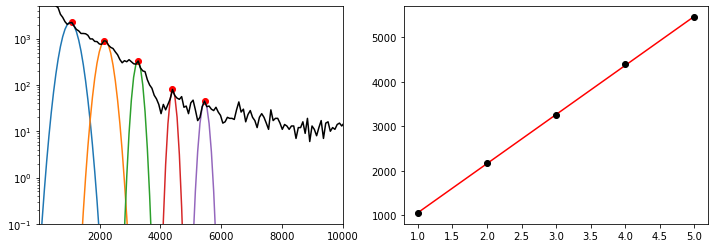

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.90OV_310_0.h5
Distance:  40
Guess:  [1343, 1465.4518348623853, 50]
Params:  [1855.67844767  534.46732346  998.50962292]
Guess:  [196, 3043.630733944954, 50]
Params:  [ 305.85807132 2001.2577259  1023.0802227 ]
Guess:  [60, 4621.809633027523, 50]
Params:  [  56.93360663 4586.63479952  419.17963021]
Guess:  [44, 5824.231651376147, 50]
Params:  [  39.21656623 5788.59087061  397.82143033]
Guess:  [39, 7026.65366972477, 50]
Params:  [  28.64890167 6831.6995343   616.7139988 ]
[1855.67844767  534.46732346  998.50962292]
[ 305.85807132 2001.2577259  1023.0802227 ]
[  56.93360663 4586.63479952  419.17963021]
[  39.21656623 5788.59087061  397.82143033]
[  28.64890167 6831.6995343   616.7139988 ]


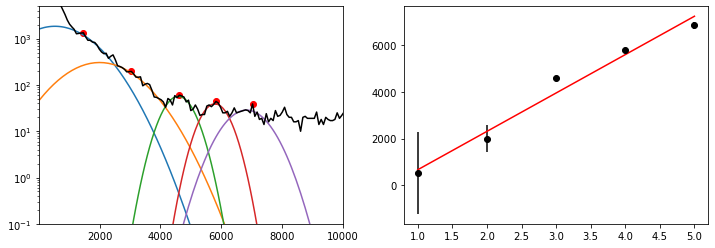

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.40OV_405_0.h5
Distance:  35
Guess:  [2869, 939.3922018348624, 50]
Params:  [2555.32771608  956.52675382  163.13510201]
Guess:  [1484, 1991.5114678899083, 50]
Params:  [1487.19804973 1985.82188223   86.71091219]
Guess:  [459, 3043.630733944954, 50]
Params:  [ 508.3066377  3006.64010588   81.88471072]
Guess:  [162, 4020.5986238532114, 50]
Params:  [ 162.33207403 4013.30014118  114.04598542]
Guess:  [103, 5072.717889908257, 50]
Params:  [ 103.76407713 5058.30518244  118.54507899]
[2555.32771608  956.52675382  163.13510201]
[1487.19804973 1985.82188223   86.71091219]
[ 508.3066377  3006.64010588   81.88471072]
[ 162.33207403 4013.30014118  114.04598542]
[ 103.76407713 5058.30518244  118.54507899]


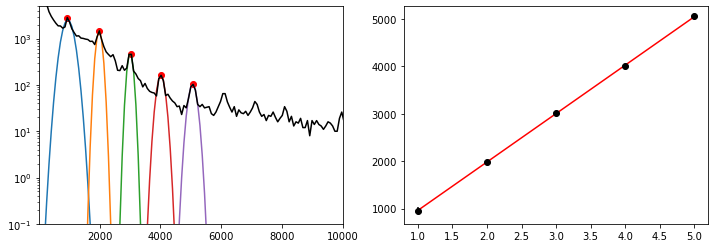

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.40OV_310_0.h5
Distance:  35
Guess:  [1421, 1014.5435779816514, 50]
Params:  [1383.42834517  831.37775099  648.22848669]
Guess:  [566, 2066.6628440366976, 50]
Params:  [ 678.34435531 1657.10953072  568.26539845]
Guess:  [246, 3118.782110091743, 50]
Params:  [ 195.1216483  3018.61167338  331.66271769]
Guess:  [110, 4170.901376146789, 50]
Params:  [  82.22687329 4169.16693579  225.16123069]
Guess:  [95, 5147.869266055046, 50]
Params:  [  69.784975   5180.07554026  232.79086683]
[1383.42834517  831.37775099  648.22848669]
[ 678.34435531 1657.10953072  568.26539845]
[ 195.1216483  3018.61167338  331.66271769]
[  82.22687329 4169.16693579  225.16123069]
[  69.784975   5180.07554026  232.79086683]


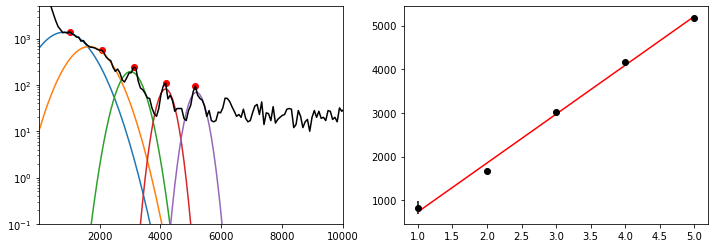

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_32.90OV_405_0.h5
Distance:  30
Guess:  [4109, 864.2408256880733, 50]
Params:  [3594.31471214  855.35113515   92.47795189]
Guess:  [1541, 1841.2087155963302, 50]
Params:  [1701.95528259 1803.99484289   83.48611272]
Guess:  [660, 2743.025229357798, 50]
Params:  [ 661.5402913  2747.35898421   63.47066078]
Guess:  [273, 3644.8417431192656, 50]
Params:  [ 307.38005885 3679.6261727    71.41730269]
Guess:  [167, 4621.809633027523, 50]
Params:  [ 167.29291234 4626.23822835   74.80501175]
[3594.31471214  855.35113515   92.47795189]
[1701.95528259 1803.99484289   83.48611272]
[ 661.5402913  2747.35898421   63.47066078]
[ 307.38005885 3679.6261727    71.41730269]
[ 167.29291234 4626.23822835   74.80501175]


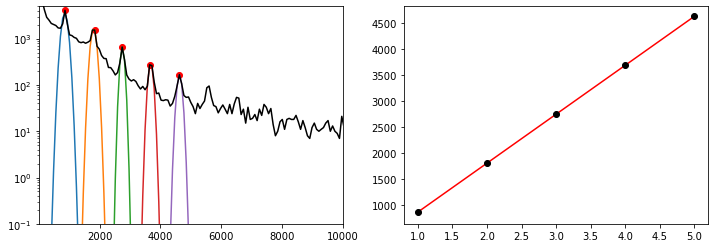

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_32.90OV_310_0.h5
Distance:  30
Guess:  [2400, 864.2408256880733, 50]
Params:  [2064.80365252  807.73119148  373.21418513]
Guess:  [1284, 1841.2087155963302, 50]
Params:  [ 967.11127622 1671.85208758  350.76008827]
Guess:  [411, 2818.1766055045873, 50]
Params:  [ 276.2501751  2627.58155926  374.84197394]
Guess:  [251, 3719.993119266055, 50]
Params:  [ 174.98720291 3722.46078237  239.56159717]
Guess:  [158, 4696.9610091743125, 50]
Params:  [ 120.58575932 4692.66278952  225.69552548]
[2064.80365252  807.73119148  373.21418513]
[ 967.11127622 1671.85208758  350.76008827]
[ 276.2501751  2627.58155926  374.84197394]
[ 174.98720291 3722.46078237  239.56159717]
[ 120.58575932 4692.66278952  225.69552548]


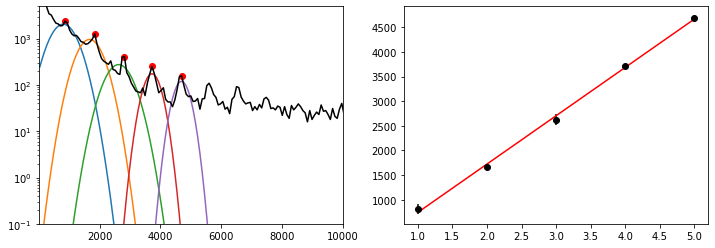

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_32.40OV_405_0.h5
Distance:  25
Guess:  [4803, 789.0894495412845, 50]
Params:  [4565.86137914  770.75383554   74.43459835]
Guess:  [2286, 1615.7545871559632, 50]
Params:  [2350.30094728 1631.70652164   67.72461761]
Guess:  [785, 2517.571100917431, 50]
Params:  [ 827.41997627 2497.58848632   61.59225124]
Guess:  [399, 3344.2362385321103, 50]
Params:  [ 399.41892161 3347.38809625   68.79955298]
Guess:  [182, 4170.901376146789, 50]
Params:  [ 199.38115758 4205.97712124   82.12335867]
[4565.86137914  770.75383554   74.43459835]
[2350.30094728 1631.70652164   67.72461761]
[ 827.41997627 2497.58848632   61.59225124]
[ 399.41892161 3347.38809625   68.79955298]
[ 199.38115758 4205.97712124   82.12335867]


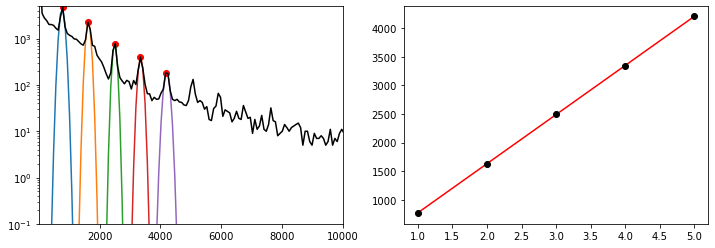

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_32.40OV_310_0.h5
Distance:  25
Guess:  [3560, 789.0894495412845, 50]
Params:  [2408.06003367  787.63277356  219.9028673 ]
Guess:  [1638, 1690.9059633027523, 50]
Params:  [1028.98522937 1597.97711107  309.3536578 ]
Guess:  [1095, 2517.571100917431, 50]
Params:  [1028.66858673 2509.50786121   70.08594284]
Guess:  [614, 3344.2362385321103, 50]
Params:  [ 591.50855103 3370.53142417   82.04142463]
Guess:  [395, 4246.052752293578, 50]
Params:  [ 266.80728954 4226.85845501  186.11582043]
[2408.06003367  787.63277356  219.9028673 ]
[1028.98522937 1597.97711107  309.3536578 ]
[1028.66858673 2509.50786121   70.08594284]
[ 591.50855103 3370.53142417   82.04142463]
[ 266.80728954 4226.85845501  186.11582043]


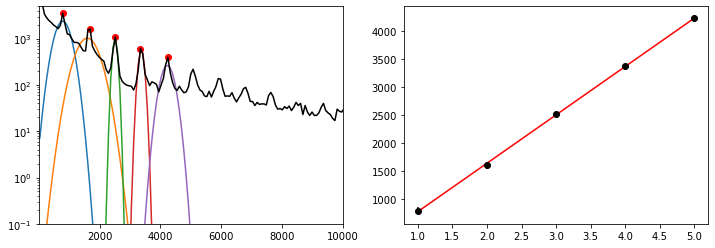

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_31.90OV_405_0.h5
Distance:  25
Guess:  [4992, 713.9380733944954, 50]
Params:  [5305.36477427  680.15007927   76.36220964]
Guess:  [2457, 1465.4518348623853, 50]
Params:  [2473.43770315 1458.08694469   63.77605417]
Guess:  [904, 2216.965596330275, 50]
Params:  [ 915.3878337  2227.16554668   64.46252475]
Guess:  [316, 3043.630733944954, 50]
Params:  [ 351.02868255 3006.33408474   81.33927923]
Guess:  [152, 3795.1444954128438, 50]
Params:  [ 156.13650744 3776.95303232   78.50173616]
[5305.36477427  680.15007927   76.36220964]
[2473.43770315 1458.08694469   63.77605417]
[ 915.3878337  2227.16554668   64.46252475]
[ 351.02868255 3006.33408474   81.33927923]
[ 156.13650744 3776.95303232   78.50173616]


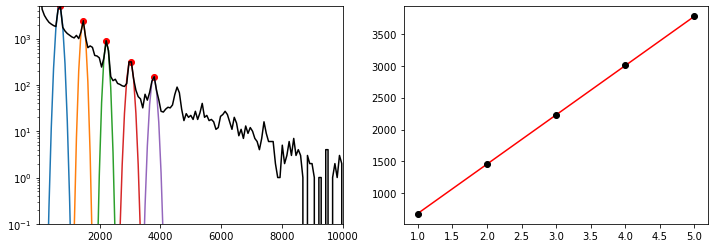

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_31.90OV_310_0.h5
Distance:  25
Guess:  [4353, 713.9380733944954, 50]
Params:  [3670.25946835  697.22901687  102.81410306]
Guess:  [2797, 1465.4518348623853, 50]
Params:  [2551.29032305 1471.48509276   70.91385959]
Guess:  [1388, 2216.965596330275, 50]
Params:  [1487.80790912 2244.92648391   64.12220416]
Guess:  [895, 3043.630733944954, 50]
Params:  [ 907.87565899 3023.18182917   68.65349852]
Guess:  [532, 3795.1444954128438, 50]
Params:  [ 439.84575556 3790.54855097  114.12607777]
[3670.25946835  697.22901687  102.81410306]
[2551.29032305 1471.48509276   70.91385959]
[1487.80790912 2244.92648391   64.12220416]
[ 907.87565899 3023.18182917   68.65349852]
[ 439.84575556 3790.54855097  114.12607777]


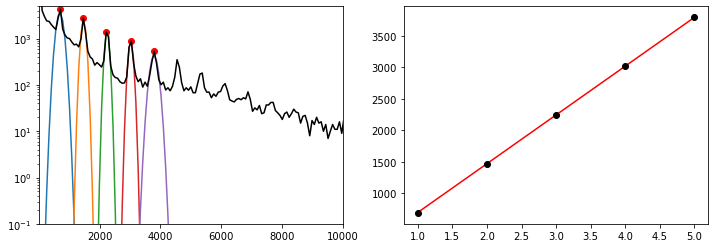

Working on file #10: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_31.40OV_405_0.h5
Distance:  25
Guess:  [4988, 563.6353211009175, 50]
Params:  [4862.77987009  593.12296961   88.76498141]
Guess:  [2271, 1315.1490825688074, 50]
Params:  [2418.34194473 1292.12756868   64.92697148]
Guess:  [947, 1991.5114678899083, 50]
Params:  [ 976.96472967 1976.28545503   61.00030529]
Guess:  [414, 2667.873853211009, 50]
Params:  [ 414.76672824 2664.38508339   57.3505628 ]
Guess:  [154, 3344.2362385321103, 50]
Params:  [ 155.73326001 3354.96257887   71.69376269]
[4862.77987009  593.12296961   88.76498141]
[2418.34194473 1292.12756868   64.92697148]
[ 976.96472967 1976.28545503   61.00030529]
[ 414.76672824 2664.38508339   57.3505628 ]
[ 155.73326001 3354.96257887   71.69376269]


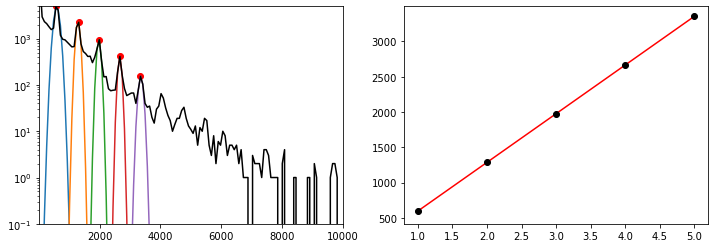

Working on file #11: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_31.40OV_310_0.h5
Distance:  25
Guess:  [4028, 563.6353211009175, 50]
Params:  [3640.23953139  583.08016375  133.90919693]
Guess:  [3301, 1315.1490825688074, 50]
Params:  [3312.4067389  1296.16221984   61.24932339]
Guess:  [2004, 1991.5114678899083, 50]
Params:  [1967.21412901 1986.6048446    57.98625415]
Guess:  [1077, 2667.873853211009, 50]
Params:  [1028.24508916 2671.45780505   68.90551628]
Guess:  [597, 3344.2362385321103, 50]
Params:  [ 562.31728183 3360.07308998   79.06061525]
[3640.23953139  583.08016375  133.90919693]
[3312.4067389  1296.16221984   61.24932339]
[1967.21412901 1986.6048446    57.98625415]
[1028.24508916 2671.45780505   68.90551628]
[ 562.31728183 3360.07308998   79.06061525]


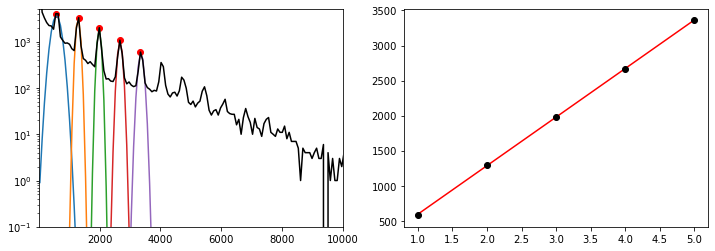

Working on file #12: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_30.90OV_405_0.h5
Distance:  20
Guess:  [6461, 488.48394495412845, 50]
Params:  [5714.43411375  492.18787067   84.50293754]
Guess:  [2410, 1089.6949541284403, 50]
Params:  [2478.02775327 1105.50355063   66.99973204]
Guess:  [1009, 1690.9059633027523, 50]
Params:  [1035.72436865 1707.36993916   72.0038998 ]
Guess:  [293, 2292.1169724770643, 50]
Params:  [ 306.58504645 2320.74509246   95.08685852]
Guess:  [153, 2968.4793577981654, 50]
Params:  [ 161.47344323 2943.47503605   76.15431934]
[5714.43411375  492.18787067   84.50293754]
[2478.02775327 1105.50355063   66.99973204]
[1035.72436865 1707.36993916   72.0038998 ]
[ 306.58504645 2320.74509246   95.08685852]
[ 161.47344323 2943.47503605   76.15431934]


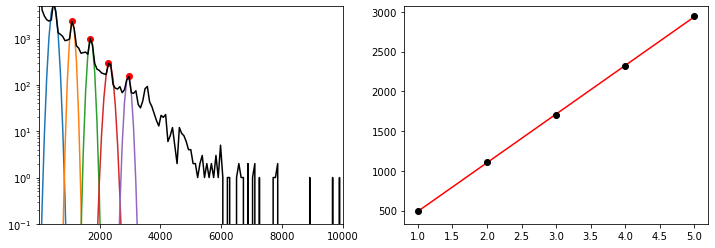

Working on file #13: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_30.90OV_310_0.h5
Distance:  20
Guess:  [5835, 488.48394495412845, 50]
Params:  [5055.16512423  504.90238172   93.08602599]
Guess:  [3474, 1089.6949541284403, 50]
Params:  [3489.66007707 1113.49266402   72.97016159]
Guess:  [1986, 1690.9059633027523, 50]
Params:  [2117.70113231 1717.79635412   69.21824518]
Guess:  [956, 2367.268348623853, 50]
Params:  [1118.08724782 2329.58483344   64.7291712 ]
Guess:  [582, 2968.4793577981654, 50]
Params:  [ 615.84449967 2934.07956235   75.45508145]
[5055.16512423  504.90238172   93.08602599]
[3489.66007707 1113.49266402   72.97016159]
[2117.70113231 1717.79635412   69.21824518]
[1118.08724782 2329.58483344   64.7291712 ]
[ 615.84449967 2934.07956235   75.45508145]


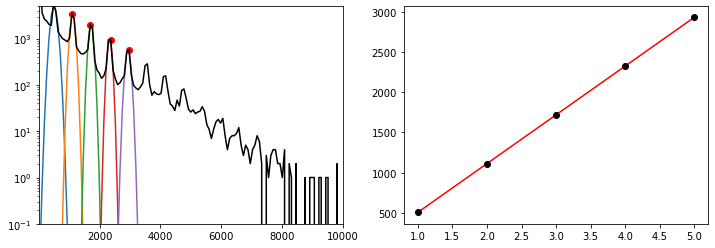

Working on file #14: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_30.40OV_405_0.h5
Distance:  15
Guess:  [7282, 413.33256880733944, 50]
Params:  [7095.77794444  416.32455913   60.65332246]
Guess:  [2856, 939.3922018348624, 50]
Params:  [2856.00115088  939.33577316   62.85626865]
Guess:  [1106, 1465.4518348623853, 50]
Params:  [1110.00300325 1459.86471017   65.72798724]
Guess:  [294, 1991.5114678899083, 50]
Params:  [ 311.19140501 1970.81288645   61.39639174]
Guess:  [82, 2517.571100917431, 50]
Params:  [  84.21276761 2501.72395768   68.67085356]
[7095.77794444  416.32455913   60.65332246]
[2856.00115088  939.33577316   62.85626865]
[1110.00300325 1459.86471017   65.72798724]
[ 311.19140501 1970.81288645   61.39639174]
[  84.21276761 2501.72395768   68.67085356]


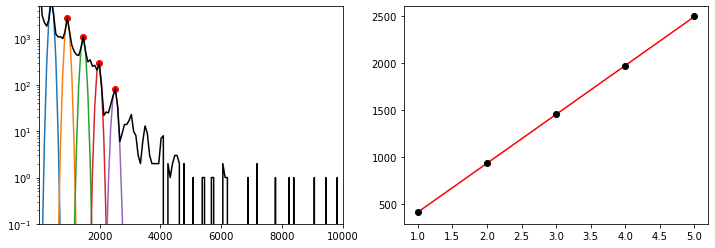

Working on file #15: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_30.40OV_310_0.h5
Distance:  15
Guess:  [6172, 413.33256880733944, 50]
Params:  [6094.49005308  419.08497307   54.92802751]
Guess:  [4217, 939.3922018348624, 50]
Params:  [4212.52955448  944.73964996   51.8456808 ]
Guess:  [2563, 1465.4518348623853, 50]
Params:  [2545.50824974 1463.65135029   52.35657505]
Guess:  [1255, 1991.5114678899083, 50]
Params:  [1244.61049135 1985.14700221   56.75185394]
Guess:  [631, 2517.571100917431, 50]
Params:  [ 617.55089446 2501.0153264    66.54093069]
[6094.49005308  419.08497307   54.92802751]
[4212.52955448  944.73964996   51.8456808 ]
[2545.50824974 1463.65135029   52.35657505]
[1244.61049135 1985.14700221   56.75185394]
[ 617.55089446 2501.0153264    66.54093069]


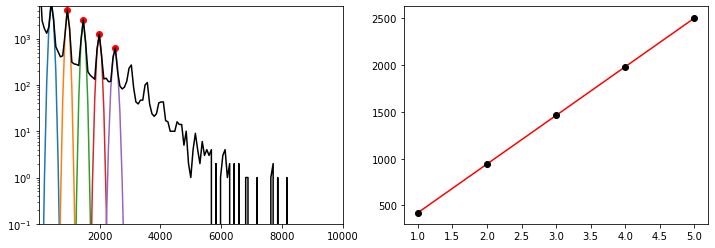

Working on file #16: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_29.90OV_405_0.h5
Distance:  15
Guess:  [2291, 789.0894495412845, 50]
Params:  [2345.09060945  766.24023438   61.08406809]
Guess:  [698, 1164.8463302752293, 50]
Params:  [ 732.43119955 1190.95566204   84.13587647]
Guess:  [300, 1615.7545871559632, 50]
Params:  [ 301.31166614 1622.52209741   72.44972539]
Guess:  [92, 2066.6628440366976, 50]
Params:  [  95.01534313 2044.51024435   87.22603555]
Guess:  [44, 2442.4197247706425, 50]
Params:  [  44.40387275 2420.7501997   160.2991639 ]
[2345.09060945  766.24023438   61.08406809]
[ 732.43119955 1190.95566204   84.13587647]
[ 301.31166614 1622.52209741   72.44972539]
[  95.01534313 2044.51024435   87.22603555]
[  44.40387275 2420.7501997   160.2991639 ]


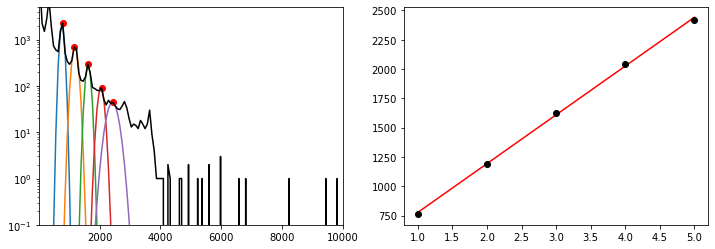

Working on file #17: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_29.90OV_310_0.h5
Distance:  15
Guess:  [4181, 789.0894495412845, 50]
Params:  [4420.60700878  769.9126288    52.58782024]
Guess:  [1998, 1239.9977064220184, 50]
Params:  [2404.14494486 1204.14245892   58.93807754]
Guess:  [1176, 1615.7545871559632, 50]
Params:  [1221.70002773 1631.19821041   55.92836144]
Guess:  [539, 2066.6628440366976, 50]
Params:  [ 539.05774606 2067.53761541   59.76190083]
Guess:  [216, 2517.571100917431, 50]
Params:  [ 220.41577587 2504.46889569   65.12589442]
[4420.60700878  769.9126288    52.58782024]
[2404.14494486 1204.14245892   58.93807754]
[1221.70002773 1631.19821041   55.92836144]
[ 539.05774606 2067.53761541   59.76190083]
[ 220.41577587 2504.46889569   65.12589442]


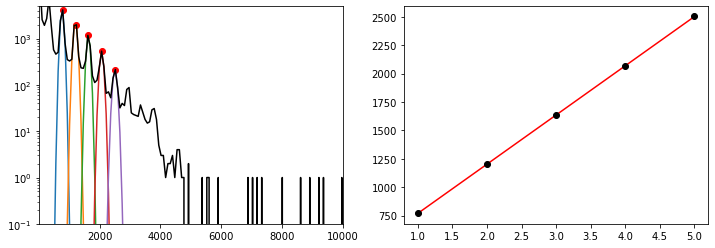

Working on file #18: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_29.40OV_405_0.h5
Distance:  10
Guess:  [2124, 563.6353211009175, 50]
Params:  [1933.65408695  581.43927663   90.23626098]
Guess:  [761, 939.3922018348624, 50]
Params:  [761.32548398 937.18616809  75.4346886 ]
Guess:  [328, 1239.9977064220184, 50]
Params:  [ 328.04151166 1243.97308708  249.87874423]
Guess:  [107, 1991.5114678899083, 50]
Params:  [ 108.86151401 1976.10228727   82.9657077 ]
Guess:  [28, 2592.7224770642206, 50]
Params:  [  36.52719309 2556.35080962   49.8801612 ]
[1933.65408695  581.43927663   90.23626098]
[761.32548398 937.18616809  75.4346886 ]
[ 328.04151166 1243.97308708  249.87874423]
[ 108.86151401 1976.10228727   82.9657077 ]
[  36.52719309 2556.35080962   49.8801612 ]


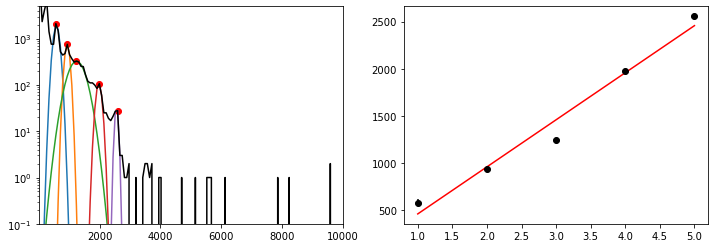

Working on file #19: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_29.40OV_310_0.h5
Distance:  10
Guess:  [4209, 563.6353211009175, 50]
Params:  [4545.95974018  586.18775301   55.61213181]
Guess:  [2472, 939.3922018348624, 50]
Params:  [2472.05213367  939.72383233   51.06305848]
Guess:  [899, 1315.1490825688074, 50]
Params:  [ 990.43630168 1287.4236371    62.99203697]
Guess:  [409, 1615.7545871559632, 50]
Params:  [ 410.43127777 1621.38587211   67.37078268]
Guess:  [189, 1991.5114678899083, 50]
Params:  [ 197.38237462 1971.49645755   67.9386433 ]
[4545.95974018  586.18775301   55.61213181]
[2472.05213367  939.72383233   51.06305848]
[ 990.43630168 1287.4236371    62.99203697]
[ 410.43127777 1621.38587211   67.37078268]
[ 197.38237462 1971.49645755   67.9386433 ]


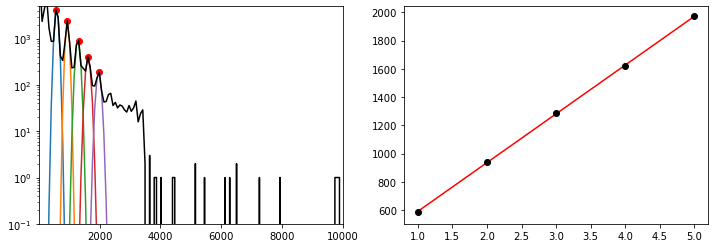

In [8]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

gain_vs_volts = {}
for i,(file, dist) in enumerate(zip(file_list, LED_distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data

    
    # finding the section of the data around the given peak
    if file_wavelength == 405.:
        peak_range = 150 # picking a smaller range of values to fit the 405 data
    elif file_volts < 30:
        peak_range = 150 # picking a smaller range of values to fit over for the lower OV files
    else:
        peak_range = 500

    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 75)
    
    # getting the peak and fit info
    if (file_wavelength != 'source') & (file_volts < 32): # if low OV data, first PE peak is a little lower
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist/3, min_thresh=5, peak_range=peak_range)
    
    else:
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist/3, peak_range=peak_range)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    
    for fit_params in peak_info:
        print(fit_params)
        plt.plot(b, gauss_fun(b, *fit_params))
    
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
#     plt.ylim(0.1, 350)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, 5000)
#     plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 10000)
    
#     plt.xlim(0, guess_1pe*6)

### don't think that we are using this
#     if(len(gain_vs_volts) > 0):
#         guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    plt.plot( xx, lin_fun(xx, *gain_params), 'r')
    
    if file_wavelength not in gain_vs_volts:
        gain_vs_volts[file_wavelength] = [np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])])]
        
    else:
        gain_vs_volts[file_wavelength].append(np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])]))

    plt.show()

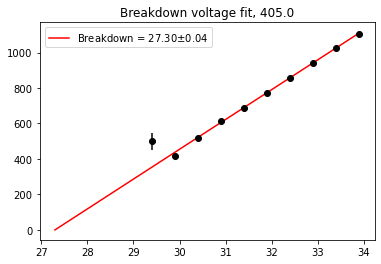

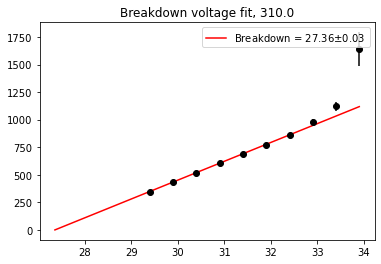

In [9]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
wavelengths = [405., 310.] #['source']
# gain_vs_volts[wavelengths] = np.asarray(gain_vs_volts[wavelengths])

for wl in wavelengths:
    breakdown, break_cov = find_bv(gain_vs_volts, wl)
    
    bv_data = np.asarray(gain_vs_volts[wl])
    plt.figure()
    plt.errorbar(bv_data[:,0], bv_data[:,1], yerr=bv_data[:,2], fmt='ko')
    x_bv = np.linspace(breakdown[1], np.max(bv_data[:,0]), 100)
    plt.plot(x_bv, lin_fun(x_bv,*breakdown), 'r', label="Breakdown = %.2f$\pm$%.2f"%(breakdown[1], np.sqrt(break_cov[1,1])))
    plt.title("Breakdown voltage fit, {}".format(wl))
    plt.legend()
    plt.show()
    
# wl_to_use = gain_vs_volts[:,3] == 405 ###### was this only to select 405 nm data?
# print(wl_to_use)
# print(np.array(gain_vs_volts[wl_to_use,:]))

Found 10 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.90OV_405_0.h5
Found 10 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step3/mca_keith_33.90OV_310_0.h5


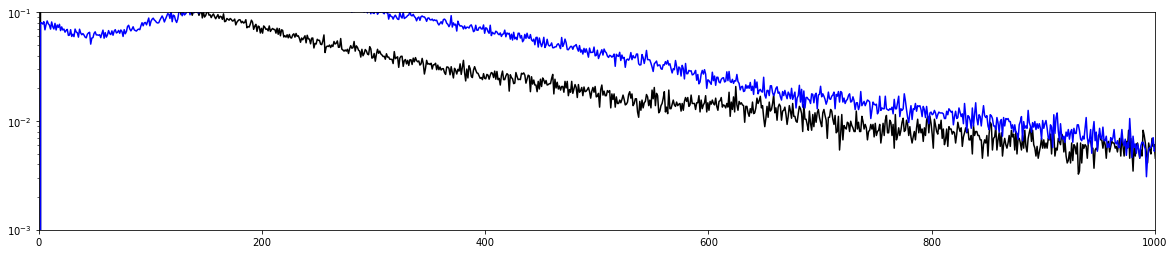

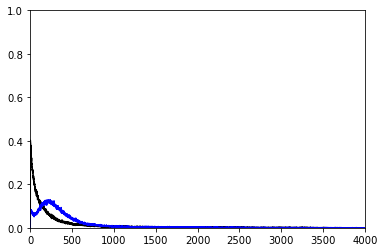

In [10]:
## Plot latest file

# path = r"C:/Data/20230213/Step/"

type_list = ['405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()

### Trying out another file

In [11]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 10
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 40))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        
#         plt.yscale('log')
#         plt.plot(x_data[cut], y_data[cut], alpha=0.5)
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
            print('Guess: ', initial_guess)
            print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            params = initial_guess
            peak_params.append(initial_guess)
            gain_info.append([peak, mean_guess, np.nan])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks)

In [12]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path_9 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/'
SRS_gain_9 = 10 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal_9 = 275 # center of noise pedestal peak

file_list_9 = natsort.realsorted(glob.glob(path_9 + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list_9))

Found 10 files


Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_33.90OV_source_0.h5
Distance:  40
Guess:  [196, 325.0595238095238, 10]
Params:  [173.01267769 323.07277176  33.19245736]
Guess:  [91, 485.0888278388278, 10]
Params:  [ 80.85953991 469.90175658  49.49176537]
Guess:  [53, 615.1126373626373, 10]
Params:  [ 46.05186444 633.99761876  80.90819054]
Guess:  [43, 795.1456043956044, 10]
Params:  [ 34.49777109 788.4338205   58.76170206]
Guess:  [34, 935.1712454212454, 10]
Params:  [ 27.13623288 942.4691399   59.14770963]
[173.01267769 323.07277176  33.19245736]
[ 80.85953991 469.90175658  49.49176537]
[ 46.05186444 633.99761876  80.90819054]
[ 34.49777109 788.4338205   58.76170206]
[ 27.13623288 942.4691399   59.14770963]


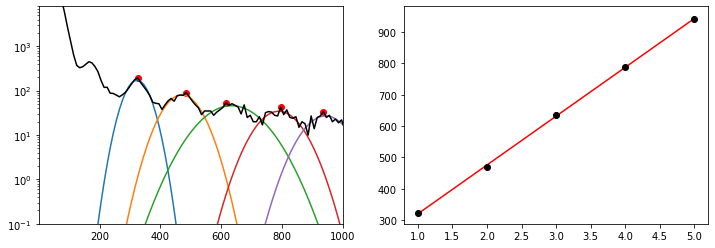

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_33.40OV_source_0.h5
Distance:  35
Guess:  [208, 305.0558608058608, 10]
Params:  [178.97102393 298.59496221  33.6272337 ]
Guess:  [111, 445.08150183150184, 10]
Params:  [ 96.27836636 442.85023191  37.17308605]
Guess:  [63, 595.1089743589744, 10]
Params:  [ 54.33285179 588.59074031  42.57100457]
Guess:  [37, 735.1346153846154, 10]
Params:  [ 32.33132443 720.60667421  62.42166315]
Guess:  [36, 865.1584249084249, 10]
Params:  [ 27.85307658 865.0930582   51.36215742]
[178.97102393 298.59496221  33.6272337 ]
[ 96.27836636 442.85023191  37.17308605]
[ 54.33285179 588.59074031  42.57100457]
[ 32.33132443 720.60667421  62.42166315]
[ 27.85307658 865.0930582   51.36215742]


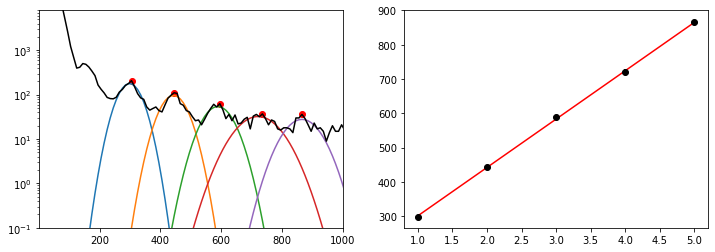

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_32.90OV_source_0.h5
Distance:  30
Guess:  [198, 275.0503663003663, 10]
Params:  [193.43673944 276.56537397  29.25894958]
Guess:  [104, 415.07600732600736, 10]
Params:  [ 92.57139858 407.2194761   39.49830635]
Guess:  [65, 545.0998168498169, 10]
Params:  [ 50.9989901  534.26028121  47.75057736]
Guess:  [38, 665.1217948717949, 10]
Params:  [ 32.80337148 660.75436218  57.37382572]
Guess:  [29, 805.1474358974359, 10]
Params:  [ 24.8837593  792.07549618  56.10226422]
[193.43673944 276.56537397  29.25894958]
[ 92.57139858 407.2194761   39.49830635]
[ 50.9989901  534.26028121  47.75057736]
[ 32.80337148 660.75436218  57.37382572]
[ 24.8837593  792.07549618  56.10226422]


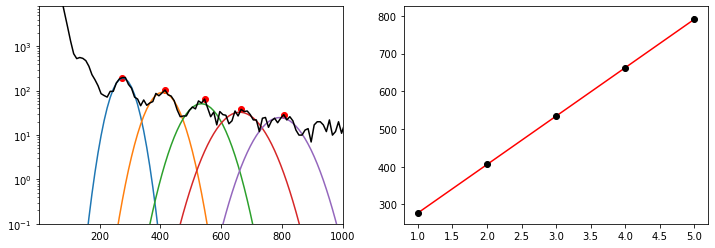

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_32.40OV_source_0.h5
Distance:  25
Guess:  [214, 265.0485347985348, 10]
Params:  [201.69341446 253.9090778   29.55945823]
Guess:  [97, 365.0668498168498, 10]
Params:  [ 83.2400667  364.67282053  47.86786013]
Guess:  [55, 485.0888278388278, 10]
Params:  [ 44.6389007  485.83686029  52.57301234]
Guess:  [37, 605.1108058608058, 10]
Params:  [ 28.840287   606.56758335  60.96817738]
Guess:  [30, 745.136446886447, 10]
Params:  [ 21.34389869 729.8418504   53.04689682]
[201.69341446 253.9090778   29.55945823]
[ 83.2400667  364.67282053  47.86786013]
[ 44.6389007  485.83686029  52.57301234]
[ 28.840287   606.56758335  60.96817738]
[ 21.34389869 729.8418504   53.04689682]


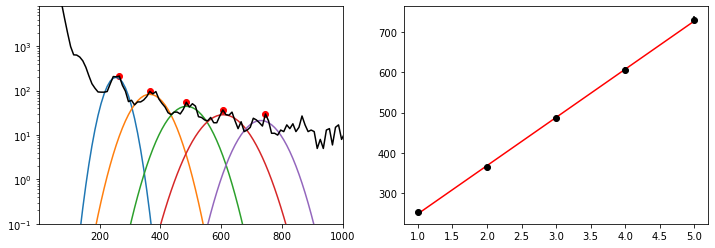

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_31.90OV_source_0.h5
Distance:  25
Guess:  [213, 235.0430402930403, 10]
Params:  [178.05027082 227.85512352  31.68045287]
Guess:  [98, 345.0631868131868, 10]
Params:  [ 82.25185024 335.09818652  44.15914488]
Guess:  [54, 445.08150183150184, 10]
Params:  [ 44.10113107 437.71500465  51.95061642]
Guess:  [39, 565.1034798534798, 10]
Params:  [ 32.83672192 551.76457776  52.54940688]
Guess:  [29, 675.1236263736264, 10]
Params:  [ 19.74606867 677.91351699  66.26645117]
[178.05027082 227.85512352  31.68045287]
[ 82.25185024 335.09818652  44.15914488]
[ 44.10113107 437.71500465  51.95061642]
[ 32.83672192 551.76457776  52.54940688]
[ 19.74606867 677.91351699  66.26645117]


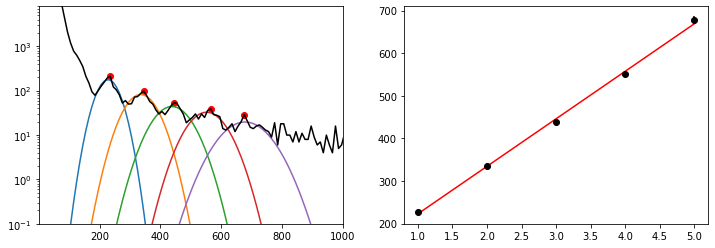

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_31.40OV_source_0.h5
Distance:  25
Guess:  [205, 195.03571428571428, 10]
Params:  [194.63004314 201.50938147  28.35861788]
Guess:  [111, 305.0558608058608, 10]
Params:  [ 94.68742715 301.51842443  30.8026168 ]
Guess:  [47, 405.0741758241758, 10]
Params:  [ 44.69912043 397.36746934  33.8669087 ]
Guess:  [27, 495.09065934065933, 10]
Params:  [ 25.34111221 480.49499209  47.12689169]
Guess:  [28, 575.1053113553114, 10]
Params:  [ 23.15635636 585.39344452  42.18196208]
[194.63004314 201.50938147  28.35861788]
[ 94.68742715 301.51842443  30.8026168 ]
[ 44.69912043 397.36746934  33.8669087 ]
[ 25.34111221 480.49499209  47.12689169]
[ 23.15635636 585.39344452  42.18196208]


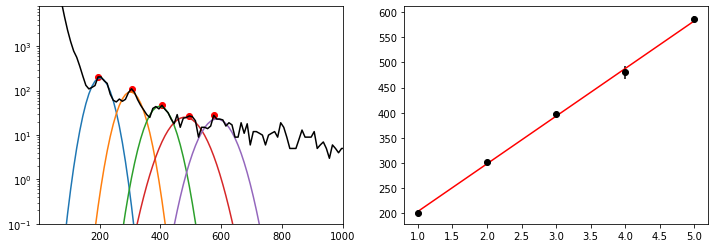

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_30.90OV_source_0.h5
Distance:  20
Guess:  [198, 185.0338827838828, 10]
Params:  [201.13880956 177.78521859  29.58524741]
Guess:  [95, 255.0467032967033, 10]
Params:  [ 85.58936321 258.80396938  47.48422587]
Guess:  [60, 355.0650183150183, 10]
Params:  [ 52.68651473 352.97232343  29.32184852]
Guess:  [35, 425.07783882783883, 10]
Params:  [ 25.68989864 430.54939944  65.86048115]
Guess:  [28, 525.0961538461538, 10]
Params:  [ 25.32862064 523.59547976  26.00327827]
[201.13880956 177.78521859  29.58524741]
[ 85.58936321 258.80396938  47.48422587]
[ 52.68651473 352.97232343  29.32184852]
[ 25.68989864 430.54939944  65.86048115]
[ 25.32862064 523.59547976  26.00327827]


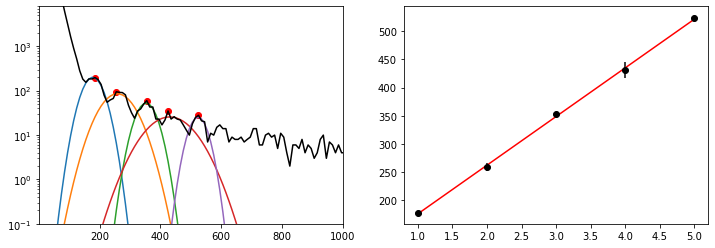

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_30.40OV_source_0.h5
Distance:  15
low voltage range
Guess:  [95, 235.0430402930403, 10]
Params:  [ 87.05705249 233.32812796  29.84278786]
Guess:  [46, 295.0540293040293, 10]
Params:  [ 45.80372533 298.48893164  27.11230675]
Guess:  [29, 355.0650183150183, 10]
Params:  [ 27.97424354 361.91392385  25.55939806]
Guess:  [23, 395.0723443223443, 10]
Params:  [ 21.06264742 379.48823071  30.33049712]
Guess:  [21, 465.08516483516485, 10]
Params:  [ 18.92326129 462.42721146  21.55236476]
[ 87.05705249 233.32812796  29.84278786]
[ 45.80372533 298.48893164  27.11230675]
[ 27.97424354 361.91392385  25.55939806]
[ 21.06264742 379.48823071  30.33049712]
[ 18.92326129 462.42721146  21.55236476]


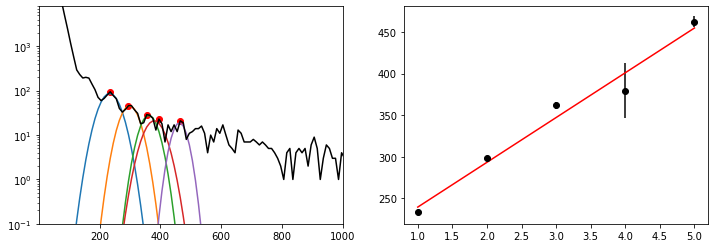

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step9/mca_keith_29.90OV_source_0.h5
Distance:  15
low voltage range
fit failed
Guess:  [51, 255.0467032967033, 10]
Params:  [ 48.62256902 252.40015289  27.72816903]
Guess:  [31, 335.0613553113553, 10]
Params:  [ 27.97459932 327.1847143   26.31005377]
Guess:  [27, 385.0705128205128, 10]
Params:  [ 19.95801421 378.89139906  28.28352799]
Guess:  [22, 435.0796703296703, 10]
Params:  [ 21.61188137 437.94435191  25.49400865]
[ 92.         175.03205128  10.        ]
[ 48.62256902 252.40015289  27.72816903]
[ 27.97459932 327.1847143   26.31005377]
[ 19.95801421 378.89139906  28.28352799]
[ 21.61188137 437.94435191  25.49400865]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

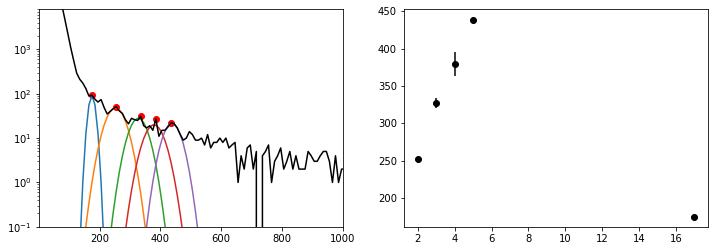

In [13]:
guess_1pe_9 = 1100 * SRS_gain_9/100 - pedestal_9 ## based on highest gain data
guess_sig_9 = 0.1

gain_vs_volts_9 = {}
for i,(file, dist) in enumerate(zip(file_list_9, source_distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data

    
    # finding the section of the data around the given peak
    if file_wavelength == 405.:
        peak_range = 150 # picking a smaller range of values to fit the 405 data
    elif file_volts < 31.5 and file_volts >=30.5:
        peak_range = 50 # picking a smaller range of values to fit over for the lower OV files
    elif file_volts < 30.5:
        print('low voltage range')
        peak_range = 30
    else:
        peak_range = 65

    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 10)
    
    # getting the peak and fit info
    if (file_wavelength != 'source') & (file_volts < 32): # if low OV data, first PE peak is a little lower
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist*25/100, min_thresh=5, peak_range=peak_range)
    
    else:
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist*25/100, min_thresh=17, peak_range=peak_range)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    
    for fit_params in peak_info:
        print(fit_params)
        plt.plot(b, gauss_fun(b, *fit_params))
    
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
#     plt.ylim(0.1, 350)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, 8000)
#     plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 1000)
    
#     plt.xlim(0, guess_1pe*6)

### don't think that we are using this
#     if(len(gain_vs_volts) > 0):
#         guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    plt.plot( xx, lin_fun(xx, *gain_params), 'r')
    
    if file_wavelength not in gain_vs_volts_9:
        gain_vs_volts_9[file_wavelength] = [np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])])]
        
    else:
        gain_vs_volts_9[file_wavelength].append(np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])]))

    plt.show()

In [14]:
len(gain_vs_volts_9['source'])

8

In [15]:
del gain_vs_volts_9['source'][-1]

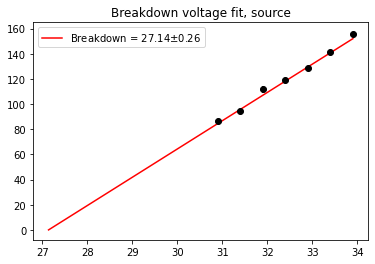

In [16]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
wavelengths = ['source']
# gain_vs_volts[wavelengths] = np.asarray(gain_vs_volts[wavelengths])

for wl in wavelengths:
    breakdown, break_cov = find_bv(gain_vs_volts_9, wl)
    
    bv_data = np.asarray(gain_vs_volts_9[wl])
    plt.figure()
    plt.errorbar(bv_data[:,0], bv_data[:,1], yerr=bv_data[:,2], fmt='ko')
    x_bv = np.linspace(breakdown[1], np.max(bv_data[:,0]), 100)
    plt.plot(x_bv, lin_fun(x_bv,*breakdown), 'r', label="Breakdown = %.2f$\pm$%.2f"%(breakdown[1], np.sqrt(break_cov[1,1])))
    plt.title("Breakdown voltage fit, {}".format(wl))
    plt.legend()
    plt.show()
    
# wl_to_use = gain_vs_volts[:,3] == 405 ###### was this only to select 405 nm data?
# print(wl_to_use)
# print(np.array(gain_vs_volts[wl_to_use,:]))

### Yet another file

In [17]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path_11 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/'
SRS_gain_11 = 10 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal_11 = 275 # center of noise pedestal peak

file_list_11 = natsort.realsorted(glob.glob(path_11 + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list_11))

Found 10 files


Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_33.90OV_source_0.h5
Distance:  40
Guess:  [220, 315.0576923076923, 10]
Params:  [183.91317713 322.13517689  29.7768683 ]
Guess:  [105, 465.08516483516485, 10]
Params:  [ 92.42686209 469.19509734  37.54541844]
Guess:  [65, 615.1126373626373, 10]
Params:  [ 56.30042409 625.11623958  41.03511049]
Guess:  [44, 785.1437728937728, 10]
Params:  [ 34.07876102 772.18184348  67.42583456]
Guess:  [38, 935.1712454212454, 10]
Params:  [ 26.87624669 934.60033038  52.71718292]
[183.91317713 322.13517689  29.7768683 ]
[ 92.42686209 469.19509734  37.54541844]
[ 56.30042409 625.11623958  41.03511049]
[ 34.07876102 772.18184348  67.42583456]
[ 26.87624669 934.60033038  52.71718292]
Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_33.40OV_source_0.h5
Distance:  35
Guess:  [196, 295.0540293040293, 10]
Params:  [180.4226496  297.56196439  30.70374814]
Guess:  [

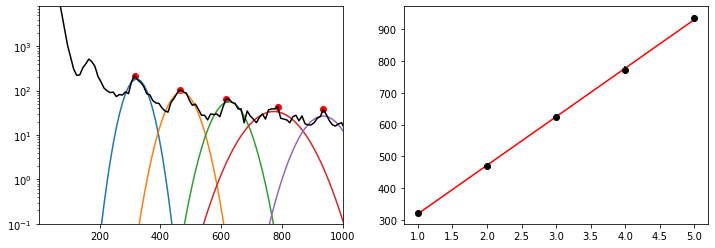

[180.4226496  297.56196439  30.70374814]
[ 77.80343355 438.69528518  45.0587869 ]
[ 48.37752808 580.66538651  51.05929609]
[ 31.15715746 724.39385234  62.51572613]
[ 25.86072513 862.64125976  56.1042157 ]
Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_32.90OV_source_0.h5
Distance:  30
Guess:  [221, 275.0503663003663, 10]
Params:  [198.29917069 276.75906438  26.42050551]
Guess:  [108, 415.07600732600736, 10]
Params:  [ 92.50789696 407.20289494  37.30235366]
Guess:  [65, 535.0979853479853, 10]
Params:  [ 57.52810052 534.57872695  44.1883955 ]
Guess:  [36, 675.1236263736264, 10]
Params:  [ 31.83157719 662.33175728  52.65622202]
Guess:  [30, 785.1437728937728, 10]
Params:  [ 26.05317498 793.53510419  61.13334171]


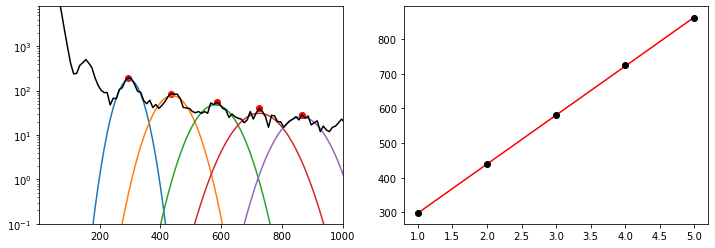

[198.29917069 276.75906438  26.42050551]
[ 92.50789696 407.20289494  37.30235366]
[ 57.52810052 534.57872695  44.1883955 ]
[ 31.83157719 662.33175728  52.65622202]
[ 26.05317498 793.53510419  61.13334171]
Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_32.40OV_source_0.h5
Distance:  25
Guess:  [210, 255.0467032967033, 10]
Params:  [197.66381964 252.83544286  25.53356664]
Guess:  [111, 365.0668498168498, 10]
Params:  [ 94.43694308 367.61481503  33.28013881]
Guess:  [66, 495.09065934065933, 10]
Params:  [ 61.13618944 491.76177006  33.42287239]
Guess:  [39, 615.1126373626373, 10]
Params:  [ 33.84615707 615.3074328   37.7004316 ]
Guess:  [29, 725.1327838827839, 10]
Params:  [ 21.44896095 726.47649559  56.3428383 ]


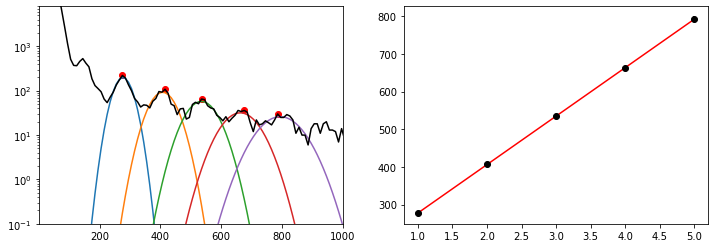

[197.66381964 252.83544286  25.53356664]
[ 94.43694308 367.61481503  33.28013881]
[ 61.13618944 491.76177006  33.42287239]
[ 33.84615707 615.3074328   37.7004316 ]
[ 21.44896095 726.47649559  56.3428383 ]
Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_31.90OV_source_0.h5
Distance:  25
Guess:  [202, 215.03937728937728, 10]
Params:  [205.28837686 225.59963926  26.93958538]
Guess:  [98, 345.0631868131868, 10]
Params:  [ 87.7178664  336.34296926  34.64151579]
Guess:  [54, 455.08333333333337, 10]
Params:  [ 48.81094814 444.64863538  36.99619735]
Guess:  [41, 535.0979853479853, 10]
Params:  [ 32.6955436  546.57053155  54.05185085]
Guess:  [26, 655.1199633699633, 10]
Params:  [ 19.59644639 646.75264486  65.56816698]


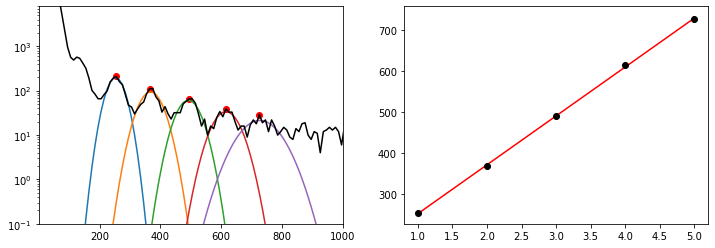

[205.28837686 225.59963926  26.93958538]
[ 87.7178664  336.34296926  34.64151579]
[ 48.81094814 444.64863538  36.99619735]
[ 32.6955436  546.57053155  54.05185085]
[ 19.59644639 646.75264486  65.56816698]
Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_31.40OV_source_0.h5
Distance:  25
Guess:  [227, 205.0375457875458, 10]
Params:  [216.23681493 206.24885278  22.40752215]
Guess:  [97, 305.0558608058608, 10]
Params:  [ 88.8385254  299.88503617  28.26266781]
Guess:  [60, 395.0723443223443, 10]
Params:  [ 55.26194746 393.43802788  28.44940033]
Guess:  [41, 485.0888278388278, 10]
Params:  [ 35.47307147 496.24595706  35.85861595]
Guess:  [23, 575.1053113553114, 10]
Params:  [ 20.30775875 594.38637043  42.80381245]


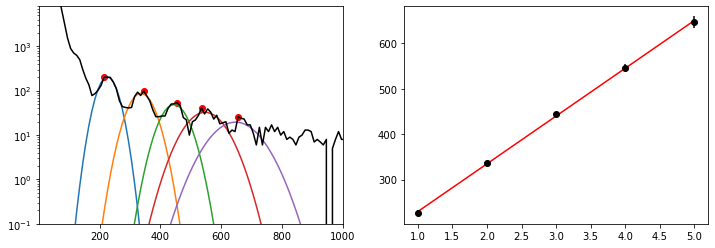

[216.23681493 206.24885278  22.40752215]
[ 88.8385254  299.88503617  28.26266781]
[ 55.26194746 393.43802788  28.44940033]
[ 35.47307147 496.24595706  35.85861595]
[ 20.30775875 594.38637043  42.80381245]
Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_30.90OV_source_0.h5
Distance:  20
Guess:  [223, 185.0338827838828, 10]
Params:  [198.9814579  181.80754534  24.73003137]
Guess:  [86, 265.0485347985348, 10]
Params:  [ 81.60980179 262.52861908  31.52868737]
Guess:  [65, 345.0631868131868, 10]
Params:  [ 52.75154707 345.74287818  32.02974749]
fit failed
Guess:  [42, 455.08333333333337, 10]
Params:  [ 31.38533665 447.27967137  29.46258774]


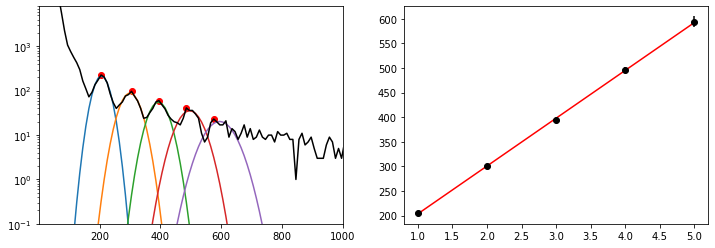

[198.9814579  181.80754534  24.73003137]
[ 81.60980179 262.52861908  31.52868737]
[ 52.75154707 345.74287818  32.02974749]
[ 20.         405.07417582  10.        ]
[ 31.38533665 447.27967137  29.46258774]
Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_30.40OV_source_0.h5
Distance:  15
low voltage range
Guess:  [105, 225.04120879120882, 10]
Params:  [ 98.94491864 220.77476988  25.34499302]
Guess:  [50, 295.0540293040293, 10]
Params:  [ 43.53341213 301.25393505  31.16813843]
Guess:  [28, 375.06868131868134, 10]
Params:  [ 26.2265256  376.64385711  30.32868678]
Guess:  [26, 455.08333333333337, 10]
Params:  [ 25.56976198 449.42563733  21.83260884]
Guess:  [16, 515.0943223443223, 10]
Params:  [ 13.53022359 519.55194866  24.38720797]


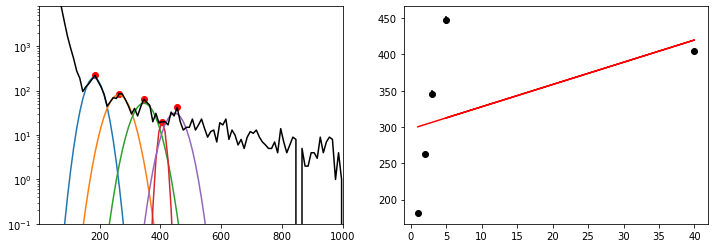

[ 98.94491864 220.77476988  25.34499302]
[ 43.53341213 301.25393505  31.16813843]
[ 26.2265256  376.64385711  30.32868678]
[ 25.56976198 449.42563733  21.83260884]
[ 13.53022359 519.55194866  24.38720797]
Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_29.90OV_source_0.h5
Distance:  15
low voltage range
Guess:  [86, 195.03571428571428, 10]
Params:  [ 80.61532543 181.35904479  36.32181125]
Guess:  [57, 255.0467032967033, 10]
Params:  [ 47.12580146 250.30813501  22.29794823]
Guess:  [30, 305.0558608058608, 10]
Params:  [ 28.14845786 315.44817227  40.85401709]
Guess:  [24, 365.0668498168498, 10]
Params:  [ 22.7252137  364.32468592  24.43602366]
fit failed


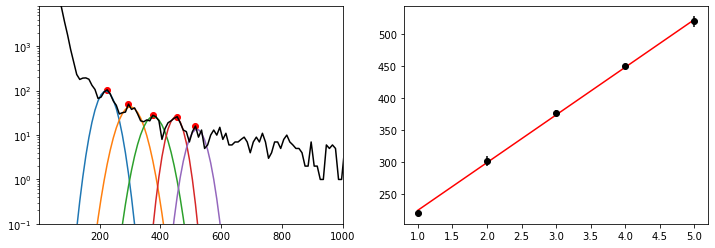

[ 80.61532543 181.35904479  36.32181125]
[ 47.12580146 250.30813501  22.29794823]
[ 28.14845786 315.44817227  40.85401709]
[ 22.7252137  364.32468592  24.43602366]
[ 16.         405.07417582  10.        ]
Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step11/mca_keith_29.40OV_source_0.h5
Distance:  15
low voltage range
Guess:  [44, 205.0375457875458, 10]
Params:  [ 55.32051466 152.32762798  70.61875792]
fit failed
Guess:  [28, 285.05219780219784, 10]
Params:  [ 29.02865008 251.36834459  63.68659302]
Guess:  [21, 335.0613553113553, 10]
Params:  [ 20.35431576 333.31198948  22.92443911]
fit failed


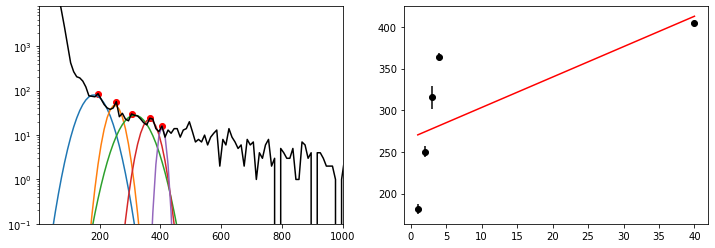

[ 55.32051466 152.32762798  70.61875792]
[ 32.         245.04487179  10.        ]
[ 29.02865008 251.36834459  63.68659302]
[ 20.35431576 333.31198948  22.92443911]
[ 12.         395.07234432  10.        ]


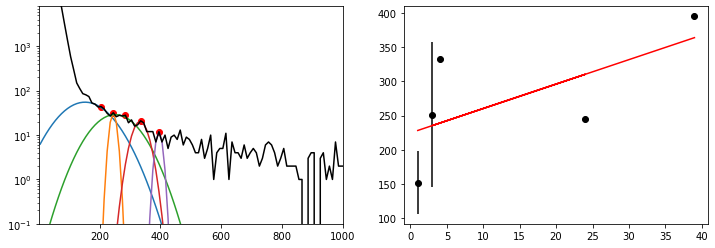

In [18]:
guess_1pe_11 = 1100 * SRS_gain_11/100 - pedestal_11 ## based on highest gain data
guess_sig_11 = 0.1

gain_vs_volts_11 = {}
for i,(file, dist) in enumerate(zip(file_list_11, source_distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data

    
    # finding the section of the data around the given peak
    if file_wavelength == 405.:
        peak_range = 150 # picking a smaller range of values to fit the 405 data
    elif file_volts < 31.5 and file_volts >=30.5:
        peak_range = 50 # picking a smaller range of values to fit over for the lower OV files
    elif file_volts < 30.5:
        print('low voltage range')
        peak_range = 30
    else:
        peak_range = 65

    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 10)
    
    # getting the peak and fit info
    if (file_wavelength != 'source') & (file_volts < 32): # if low OV data, first PE peak is a little lower
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist*25/100, min_thresh=5, peak_range=peak_range)
    
    else:
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist*25/100, min_thresh=17, peak_range=peak_range)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    
    for fit_params in peak_info:
        print(fit_params)
        plt.plot(b, gauss_fun(b, *fit_params))
    
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
#     plt.ylim(0.1, 350)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, 8000)
#     plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 1000)
    
#     plt.xlim(0, guess_1pe*6)

### don't think that we are using this
#     if(len(gain_vs_volts) > 0):
#         guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    plt.plot( xx, lin_fun(xx, *gain_params), 'r')
    
    if file_wavelength not in gain_vs_volts_11:
        gain_vs_volts_11[file_wavelength] = [np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])])]
        
    else:
        gain_vs_volts_11[file_wavelength].append(np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])]))


In [19]:
del gain_vs_volts_11['source'][-1]
del gain_vs_volts_11['source'][-1]

In [20]:
del gain_vs_volts_11['source'][-2]

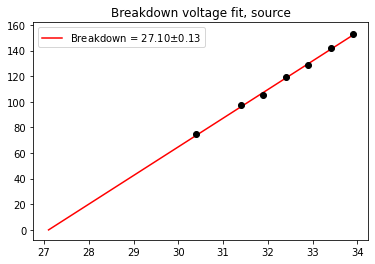

In [21]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
wavelengths = ['source']
# gain_vs_volts[wavelengths] = np.asarray(gain_vs_volts[wavelengths])

for wl in wavelengths:
    breakdown, break_cov = find_bv(gain_vs_volts_11, wl)
    
    bv_data = np.asarray(gain_vs_volts_11[wl])
    plt.figure()
    plt.errorbar(bv_data[:,0], bv_data[:,1], yerr=bv_data[:,2], fmt='ko')
    x_bv = np.linspace(breakdown[1], np.max(bv_data[:,0]), 100)
    plt.plot(x_bv, lin_fun(x_bv,*breakdown), 'r', label="Breakdown = %.2f$\pm$%.2f"%(breakdown[1], np.sqrt(break_cov[1,1])))
    plt.title("Breakdown voltage fit, {}".format(wl))
    plt.legend()
    plt.show()
    
# wl_to_use = gain_vs_volts[:,3] == 405 ###### was this only to select 405 nm data?
# print(wl_to_use)